In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt
import gensim.downloader as api
from tqdm import tqdm

In [2]:
# Load and preprocess the dataset
def load_dataset(root_dir):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        label_dir = os.path.join(root_dir, label)
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                data.append(text)
                rating = int(filename.split('_')[-1].split('.')[0])
                normalized_rating = (rating - 1) / 9.0
                labels.append(normalized_rating)
    return data, labels

train_dir = 'aclImdb_v1/aclImdb/train'
test_dir = 'aclImdb_v1/aclImdb/test'

print('Loading the dataset into memory...')
train_data, train_labels = load_dataset(train_dir)
test_data, test_labels = load_dataset(test_dir)

# Load pre-trained GloVe embeddings
print('Loading pre-trained GloVe embeddings...')
glove_vectors = api.load('glove-wiki-gigaword-100')

Loading the dataset into memory...
Loading pre-trained GloVe embeddings...


In [3]:
# Convert text data to numerical features using GloVe embeddings
def get_glove_features(data):
    features = []
    for text in data:
        words = text.lower().split()
        word_vectors = [glove_vectors[word] for word in words if word in glove_vectors]
        if len(word_vectors) > 0:
            text_vector = np.mean(word_vectors, axis=0)
        else:
            text_vector = np.zeros(100)
        features.append(text_vector)
    return np.array(features)

train_features = get_glove_features(train_data)
test_features = get_glove_features(test_data)

In [4]:
# Initialize the random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=42)

# Train the random forest regressor
print('Training the random forest regressor...')
rf_regressor.fit(train_features, train_labels)

# Make predictions on the test set
print('Making predictions on the test set...')
test_predictions = []
for feature in tqdm(test_features, desc='Predicting'):
    prediction = rf_regressor.predict([feature])
    test_predictions.append(prediction[0])

Training the random forest regressor...
Making predictions on the test set...


Predicting: 100%|█████████████████████████| 25000/25000 [05:02<00:00, 82.57it/s]


Mean Squared Error: 0.1009
Mean Absolute Error: 0.2713


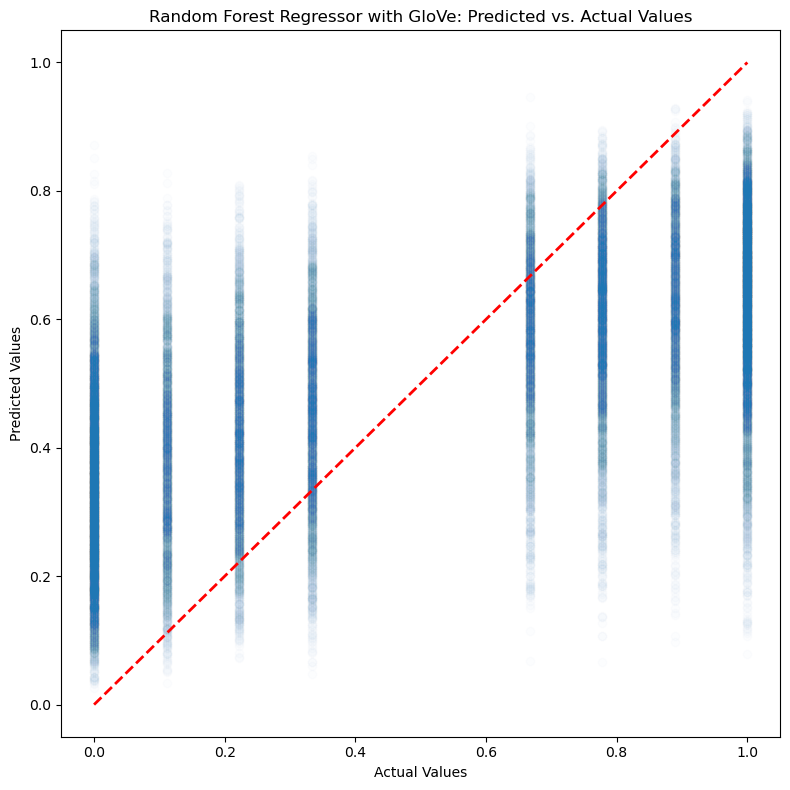

In [8]:
# Calculate the mean squared error
mse = mean_squared_error(test_labels, test_predictions)
mae = mean_absolute_error(test_labels, test_predictions)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot the predicted vs. actual values
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.01)
plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regressor with GloVe: Predicted vs. Actual Values')
plt.tight_layout()
plt.show()
plt.close()

In [12]:
# Classify reviews as 'positive' (1) or 'negative' (0)
binary_predictions = np.where(np.array(test_predictions) < 0.5, 0, 1)
binary_test_ratings = np.where(np.array(test_labels) < 0.5, 0, 1)

conf_matrix = confusion_matrix(binary_test_ratings, binary_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                      index = [ 'actual negative reviews',  'actual positive reviews'], 
                      columns = [ 'predicted negative reviews',  'predicted positive reviews'] )
conf_matrix_df

,predicted negative reviews,predicted positive reviews
actual negative reviews,9294,3206
actual positive reviews,3018,9482


In [13]:
tp = conf_matrix[1, 1]  # True Positives
fp = conf_matrix[0, 1]  # False Positives
fn = conf_matrix[1, 0]  # False Negatives
tn = conf_matrix[0, 0]  # True Negatives

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score:', f1_score)

Precision:  0.7473203026481715
Recall:  0.75856
F1 score: 0.75289820549468
